In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv(r"C:\Users\sayala\Documents\GitHub\InSPIRE\Studies\USMap_Doubleday_2024\agrivoltaics_irradiance_single_location-time-index.csv", index_col=[0])

In [3]:
df.index

Index(['2001-01-01 00:30:00', '2001-01-01 01:30:00', '2001-01-01 02:30:00',
       '2001-01-01 03:30:00', '2001-01-01 04:30:00', '2001-01-01 05:30:00',
       '2001-01-01 06:30:00', '2001-01-01 07:30:00', '2001-01-01 08:30:00',
       '2001-01-01 09:30:00',
       ...
       '2001-12-31 14:30:00', '2001-12-31 15:30:00', '2001-12-31 16:30:00',
       '2001-12-31 17:30:00', '2001-12-31 18:30:00', '2001-12-31 19:30:00',
       '2001-12-31 20:30:00', '2001-12-31 21:30:00', '2001-12-31 22:30:00',
       '2001-12-31 23:30:00'],
      dtype='object', name='time', length=8760)

In [4]:
cw = 2
pitch = 5

In [5]:
underpanel_left_start = 0
underpanel_left_end = cw/2  # u
underpanel_right_start = pitch-cw/2  # b
underpanel_right_end = pitch

In [6]:
dx = pitch/10

In [7]:
# Tracking TILT, 3 beds  (#SCENARIO 1,2,3)
xp = cw/2 # Projection of panel on P.
u = int(np.ceil(10*underpanel_left_end/pitch)) # underpanel limit integer box
b = 10-u
# Three testbeds:
e2e = b-u # dimensions of edge to edge
bA = int(np.ceil(e2e/3.0))
bC = int(bA)
bB = int(e2e-bA-bC)

underpanel = df.iloc[:,0:u].join(df.iloc[:,b:10]).mean(axis=1)
edgetoedge = df.iloc[:,u:b].mean(axis=1)
bedA = df.iloc[:,u:u+bA].mean(axis=1)
bedB = df.iloc[:,u+bA:u+bA+bB].mean(axis=1)
bedC = df.iloc[:,u+bA+bB:b].mean(axis=1)

In [8]:
df['underpanel'] = underpanel
df['edgetoedge'] = edgetoedge
df['bedA'] = bedA
df['bedB'] = bedB
df['bedC'] = bedC


In [9]:
import pvlib

In [10]:
NREL_API_KEY = None  # <-- please set your NREL API key here
# note you must use "quotes" around your key as it is a string.

if NREL_API_KEY is None:
       NREL_API_KEY = 'DEMO_KEY'  # OK for this demo, but better to get your own key

In [47]:
import pvlib

metdata, metadata = pvlib.iotools.get_psm3(
#    latitude=39.7555, longitude=-105.2211,
    latitude=37.010000, longitude=-108.900000,
#    latitude=44.25, longitude=-117.33999633789062,
    api_key=NREL_API_KEY,
    email='silvana.ovaitt@nrel.gov',  # <-- any email works here fine
    names='tmy', map_variables=True)
metadata

{'Source': 'NSRDB',
 'Location ID': '114347',
 'City': '-',
 'State': '-',
 'Country': '-',
 'Time Zone': -7,
 'Local Time Zone': -7,
 'Dew Point Units': 'c',
 'DHI Units': 'w/m2',
 'DNI Units': 'w/m2',
 'GHI Units': 'w/m2',
 'Temperature Units': 'c',
 'Pressure Units': 'mbar',
 'Wind Direction Units': 'Degrees',
 'Wind Speed Units': 'm/s',
 'Surface Albedo Units': 'N/A',
 'Version': '3.2.0',
 'latitude': 37.01,
 'longitude': -108.9,
 'altitude': 1470}

In [48]:
metdata

,Year,Month,Day,Hour,Minute,temp_air,temp_dew,dhi,dni,ghi,albedo,pressure,wind_direction,wind_speed
2020-01-01 00:30:00-07:00,2020,1,1,0,30,-8.5,-13.6,0.0,0.0,0.0,0.18,843.0,281.0,1.0
2020-01-01 01:30:00-07:00,2020,1,1,1,30,-8.9,-13.8,0.0,0.0,0.0,0.18,843.0,288.0,1.1
2020-01-01 02:30:00-07:00,2020,1,1,2,30,-9.1,-14.2,0.0,0.0,0.0,0.18,842.0,294.0,1.1
2020-01-01 03:30:00-07:00,2020,1,1,3,30,-9.3,-14.6,0.0,0.0,0.0,0.18,842.0,294.0,1.1
2020-01-01 04:30:00-07:00,2020,1,1,4,30,-9.3,-14.9,0.0,0.0,0.0,0.18,841.0,293.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2004-12-31 19:30:00-07:00,2004,12,31,19,30,-6.1,-11.4,0.0,0.0,0.0,0.18,844.0,331.0,1.0
2004-12-31 20:30:00-07:00,2004,12,31,20,30,-6.5,-11.8,0.0,0.0,0.0,0.18,844.0,327.0,0.9
2004-12-31 21:30:00-07:00,2004,12,31,21,30,-6.9,-12.3,0.0,0.0,0.0,0.18,844.0,314.0,0.9
2004-12-31 22:30:00-07:00,2004,12,31,22,30,-7.4,-12.9,0.0,0.0,0.0,0.18,844.0,296.0,1.0


In [13]:
df['ghi'] = list(metdata.ghi)

In [14]:
df['SF_underpanel'] = (1-df['underpanel']/df['ghi'])*100
df['SF_edgetoedge'] = (1-df['edgetoedge']/df['ghi'])*100
df['SF_bedA'] = (1-df['bedA']/df['ghi'])*100
df['SF_bedB'] = (1-df['bedB']/df['ghi'])*100
df['SF_bedC'] = (1-df['bedC']/df['ghi'])*100

In [15]:
# Only necessary because I don't know the real location so i'm getting neg numbers
df['SF_underpanel'] = df['SF_underpanel'].mask(df['SF_underpanel'] < 0, np.nan)
df['SF_edgetoedge'] = df['SF_edgetoedge'].mask(df['SF_edgetoedge'] < 0, np.nan)
df['SF_bedA'] = df['SF_bedA'].mask(df['SF_bedA'] < 0, np.nan)
df['SF_bedB'] = df['SF_bedB'].mask(df['SF_bedB'] < 0, np.nan)
df['SF_bedC'] = df['SF_bedC'].mask(df['SF_bedC'] < 0, np.nan)


In [16]:
df['PAR_ghi'] = df['ghi']*3600/1000000*0.43*638.89
df['PAR_underpanel'] = df['underpanel']*3600/1000000*0.43*638.89
df['PAR_edgetoedge'] = df['edgetoedge']*3600/1000000*0.43*638.89
df['PAR_bedA'] = df['bedA']*3600/1000000*0.43*638.89
df['PAR_bedB'] = df['bedB']*3600/1000000*0.43*638.89
df['PAR_bedC'] = df['bedC']*3600/1000000*0.43*638.89


In [17]:
df.to_csv('Results_Setup1_example_fix.csv')

In [19]:
df.index = pd.to_datetime(df.index)

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
monthly_average_mean = df.resample('ME').mean()
monthly_average = df.resample('ME').sum()
short_rows = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'] # list of strings with len 15
short_cols = ['panel', 'panel', 'bed West', 'bed West', 'bed Center', 'bed Center', 'bed East', 'bed East', 'panel', 'panel']


Text(297.55555555555566, 0.5, 'Month')

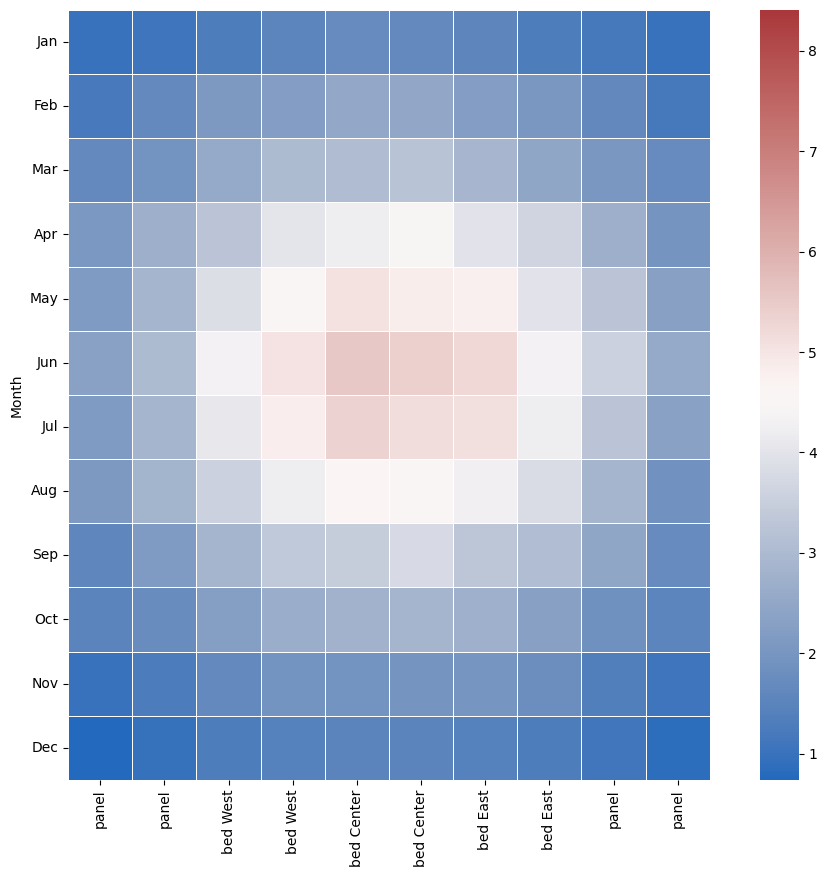

In [22]:
fig, ax = plt.subplots(figsize=(13,10)) 
sns.heatmap(monthly_average_mean.iloc[:,0:10]*24/1000, vmax = monthly_average_mean.ghi.max()*24/1000, cmap="vlag", square=True, linewidths=0.5, linecolor='white')
ax.set_xticklabels(tuple(short_cols)) # i also tried passing a list
ax.set_yticklabels(tuple(short_rows))
ax.set_ylabel('Month')


Text(297.55555555555566, 0.5, 'Month')

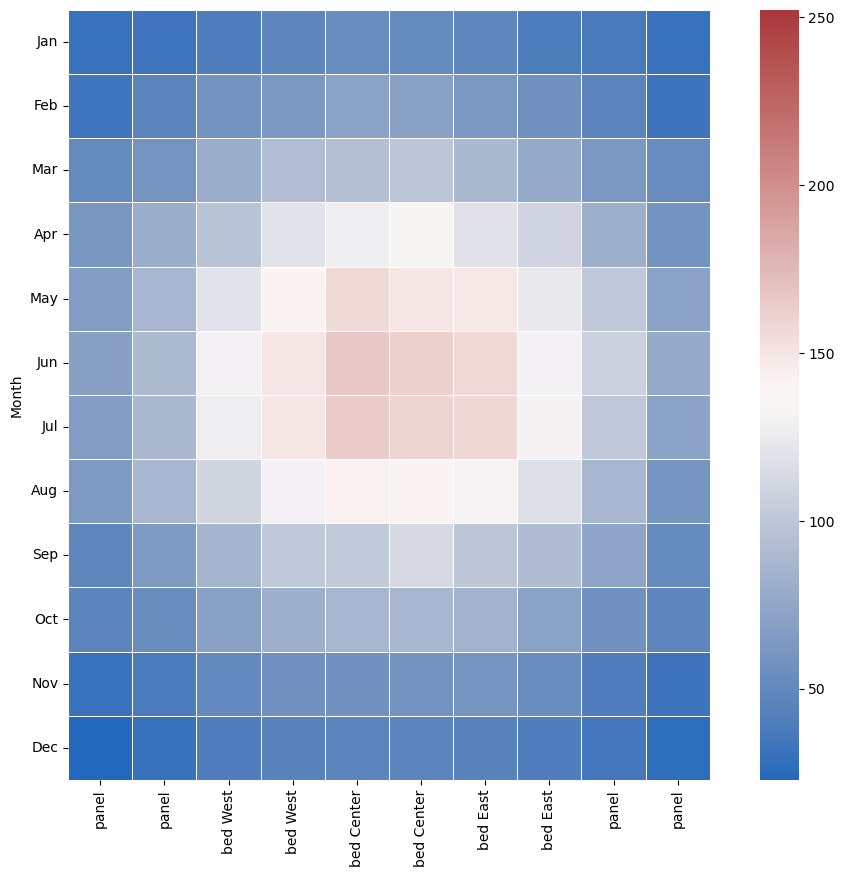

In [23]:
fig, ax = plt.subplots(figsize=(13,10)) 
sns.heatmap(monthly_average.iloc[:,0:10]/1000, vmax = monthly_average.ghi.max()/1000, cmap="vlag", square=True, linewidths=0.5, linecolor='white')
ax.set_xticklabels(tuple(short_cols)) # i also tried passing a list
ax.set_yticklabels(tuple(short_rows))
ax.set_ylabel('Month')


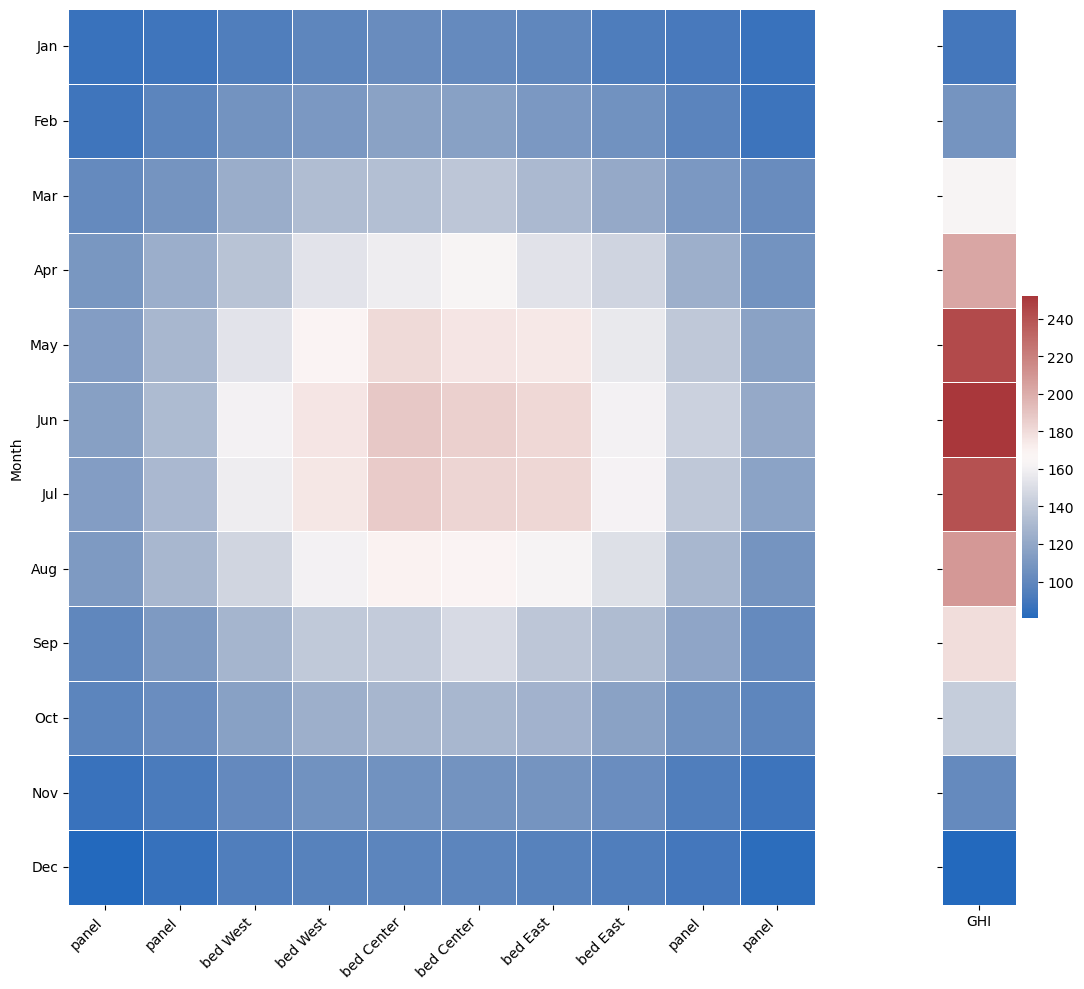

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12, 10), gridspec_kw={'width_ratios': [10, 1]}) 

# Main heatmap
sns.heatmap(monthly_average.iloc[:, 0:10]/1000, 
            vmax=monthly_average.ghi.max()/1000, 
            cmap="vlag", square=True, linewidths=0.5, 
            linecolor='white', ax=axes[0], cbar=False)

axes[0].set_xticklabels(short_cols, rotation=45, ha='right')
axes[0].set_yticklabels(short_rows)
axes[0].set_ylabel('Month')

# GHI Heatmap (Single Column)
sns.heatmap(monthly_average.iloc[:,[15]]/1000, 
            cmap="vlag", square=True, linewidths=0.5, 
            linecolor='white', ax=axes[1], cbar=True)

axes[1].set_xticklabels(['GHI'])
axes[1].set_yticklabels([])
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

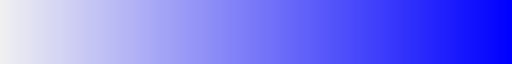

In [25]:
sns.color_palette("light:b", as_cmap=True)


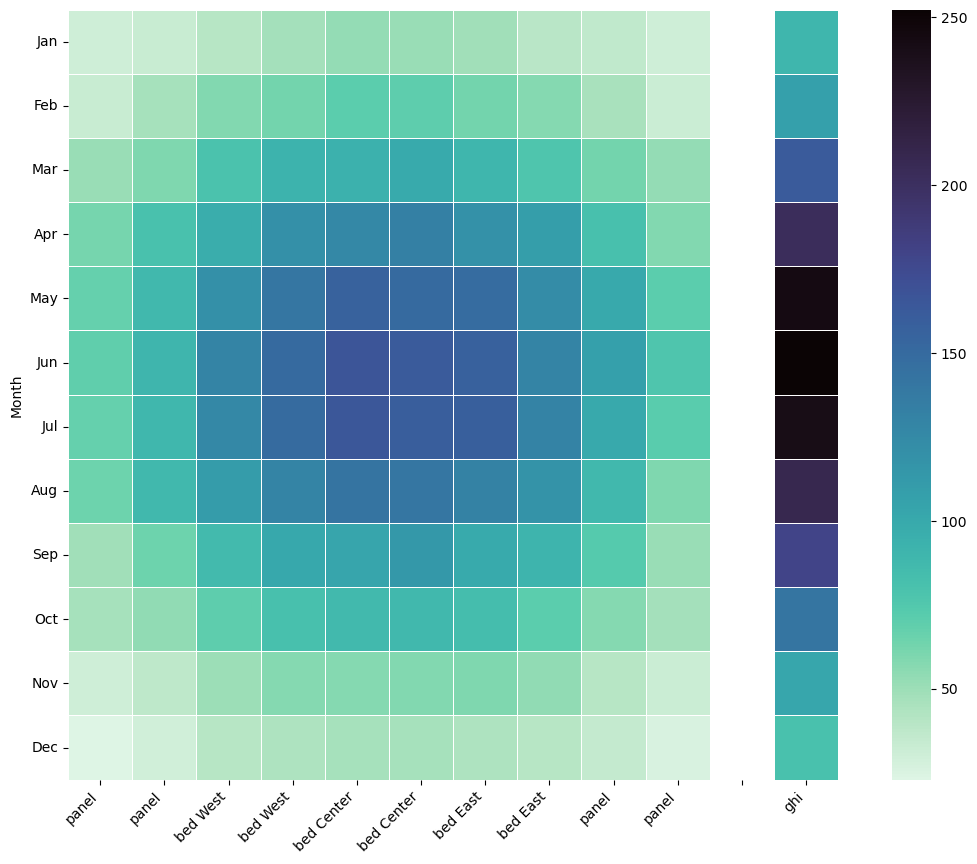

In [26]:
# Select only columns 0-9 and 15, inserting an empty column as a visual separator
selected_cols = monthly_average.iloc[:, list(range(10)) + [15]].copy()
selected_cols.insert(10, ' ', np.nan)  # Empty column for spacing

# Adjust the labels to match the new structure
short_cols_sep = short_cols + [' ', 'ghi']

fig, ax = plt.subplots(figsize=(14, 10))

sns.heatmap(selected_cols/1000, vmax=monthly_average.ghi.max()/1000,  cmap="mako_r",
            square=True, linewidths=0.5, linecolor='white', ax=ax)

# Apply the modified column labels
ax.set_xticklabels(short_cols_sep, rotation=45, ha='right')
ax.set_yticklabels(short_rows)
ax.set_ylabel('Month')

plt.show()

In [27]:
df['hour'] = df.index.hour
df['month'] = df.index.month
hourly_avg_by_month  = df.groupby(['month','hour'])['0.2502810919746036'].mean().unstack()


In [28]:
hourly_avg_by_month = hourly_avg_by_month.T

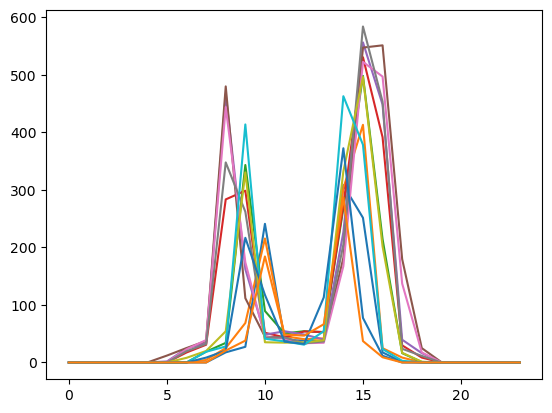

In [29]:
plt.plot(hourly_avg_by_month)

In [30]:
df.keys()

Index(['0.2502810919746036', '0.7508432759238107', '1.251405459873018',
       '1.751967643822225', '2.2525298277714323', '2.753092011720639',
       '3.2536541956698466', '3.7542163796190535', '4.2547785635682605',
       '4.755340747517468', 'underpanel', 'edgetoedge', 'bedA', 'bedB', 'bedC',
       'ghi', 'SF_underpanel', 'SF_edgetoedge', 'SF_bedA', 'SF_bedB',
       'SF_bedC', 'PAR_ghi', 'PAR_underpanel', 'PAR_edgetoedge', 'PAR_bedA',
       'PAR_bedB', 'PAR_bedC', 'hour', 'month'],
      dtype='object')

In [31]:
df['hour'] = df.index.hour
df['month'] = df.index.month
hourly_avg_by_month  = df.groupby(['month','hour'])[['0.2502810919746036', '0.7508432759238107', '1.251405459873018',
       '1.751967643822225', '2.2525298277714323', '2.753092011720639',
       '3.2536541956698466', '3.7542163796190535', '4.2547785635682605',
       '4.755340747517468']].mean().unstack(1)


In [32]:
hourly_avg_by_month = hourly_avg_by_month.T

In [33]:
hourly_avg_by_month = hourly_avg_by_month.unstack()

In [36]:
hourly_avg_by_month.to_csv('monthly hourly average.csv')

In [41]:
daily_average_mean = df.resample('D').mean()


<Axes: xlabel='time'>

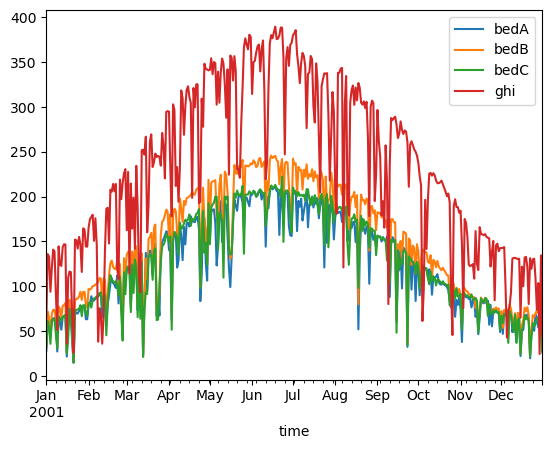

In [46]:
daily_average_mean[['bedA','bedB','bedC', 'ghi']].plot()

## OTHERS

In [ ]:
# FIXED TILT 3 Beds (i.e. # SCENARIO 6,7,8)

xp = CW*np.cos(np.radians(float(meta['Tilt(deg)']))) # Projection of panel on P.
u = int(np.ceil(10*xp/pitch)) # underpanel limit integer box
e2e = 10-u
# Three testbeds:
bA = int(np.ceil(b/3.0))
bC = int(bA)
bB = int(e2e-bA-bC)

underpanel = df.iloc[:,0:u].mean(axis=1)
underpanel.append(ground[mask].iloc[:,0:u].mean(axis=1).mean())
edgetoedge = df.iloc[u:].mean(axis=1)
bedA = df.iloc[:,u:u+bA].mean(axis=1).mean()
bedB = df.iloc[:,u+bA:u+bA+bB].mean(axis=1).mean()
bedC = df.iloc[:,u+bA+bB:].mean(axis=1).mean()

In [ ]:
# Fixed tilt, 6 beds ( # SCENARIO 9)
xp = CW*np.cos(np.radians(float(meta['Tilt(deg)']))) # Projection of panel on P.
u = int(np.ceil(10*xp/pitch)) # underpanel limit integer box
e2e = 10-u
# Three testbeds:
b1 = int(np.ceil(b/6.0))
b2 = int(e2e-b1*5)

underpanel = df.iloc[:,0:u].join(df.iloc[:,b:10]).mean(axis=1)
edgetoedge = df.iloc[u:b].mean(axis=1)
bedA = df.iloc[:,u:u+b1*1].mean(axis=1)
bedB = df.iloc[:,u+b1*1:u+b1*3].mean(axis=1)
bedC = df.iloc[:,u+b1*2:u+b1*4].mean(axis=1)
bedD = df.iloc[:,u+b1*3:u+b1*4+b2].mean(axis=1)
bedE = df.iloc[:,u+b1*4+b2:u+b1*5+b2].mean(axis=1)
bedF = df.iloc[:,u+b1*5+b2:].mean(axis=1)

In [ ]:
# Tracking, 6 beds (SCENARIO #4)
xp = cw/2 # Projection of panel on P.
u = int(np.ceil(10*underpanel_left_end/pitch)) # underpanel limit integer box
b = 10-u
# Six testbeds:
e2e = b-u # dimensions of edge to edge
bA = int(np.ceil(e2e/6.0))
bB = int(bA)
bC = int(bA)
bE = int(bA)
bF = int(bA)
bD = int(e2e-bA-bB-bC-bE-bF)

underpanel = df.iloc[:,0:u].join(df.iloc[:,b:10]).mean(axis=1)
edgetoedge = df.iloc[u:b].mean(axis=1)
bedA = df.iloc[:,u:u+bA].mean(axis=1)
bedB = df.iloc[:,u+bA:u+bA+bB].mean(axis=1)
bedC = df.iloc[:,u+bA+bB:u+bA+bB+bC].mean(axis=1)
bedD = df.iloc[:,u+bA+bB+bC:u+bA+bB+bC+bD].mean(axis=1)
bedE = df.iloc[:,u+bA+bB+bC+bD:u+bA+bB+bC+bD+bE].mean(axis=1)
bedF = df.iloc[:,u+bA+bB+bC+bD+bE:b].mean(axis=1)

In [ ]:
# Fixed tilt, VERTICAL BEDS (SCENARIO #10)
pitch = 8.6
xp = 0.6 #m Spacing from panels to not harvest and damage 
u = int(np.ceil(10*underpanel_left_end/pitch)) # underpanel limit integer box
b = 10-u
# Six testbeds:
e2e = b-u # dimensions of edge to edge
bA = int(np.ceil(e2e/6.0))
bB = int(bA)
bC = int(bA)
bE = int(bA)
bF = int(bA)
bD = int(e2e-bA-bB-bC-bE-bF)

underpanel = df.iloc[:,0:u].join(df.iloc[:,b:10]).mean(axis=1)
edgetoedge = df.iloc[u:b].mean(axis=1)
bedA = df.iloc[:,u:u+bA].mean(axis=1)
bedB = df.iloc[:,u+bA:u+bA+bB].mean(axis=1)
bedC = df.iloc[:,u+bA+bB:u+bA+bB+bC].mean(axis=1)
bedD = df.iloc[:,u+bA+bB+bC:u+bA+bB+bC+bD].mean(axis=1)
bedE = df.iloc[:,u+bA+bB+bC+bD:u+bA+bB+bC+bD+bE].mean(axis=1)
bedF = df.iloc[:,u+bA+bB+bC+bD+bE:b].mean(axis=1)


In [ ]:
# Tracking, 9 beds  ( SCENARIO #5)
xp = cw/2 # Projection of panel on P.
u = int(np.ceil(10*underpanel_left_end/pitch)) # underpanel limit integer box
b = 10-u
# Six testbeds:
e2e = b-u # dimensions of edge to edge
b1 = int(np.ceil(e2e/9.0))
b5 = int(e2e-b1*8)

underpanel = df.iloc[:,0:u].join(df.iloc[:,b:10]).mean(axis=1)
edgetoedge = df.iloc[u:b].mean(axis=1)
bedA = df.iloc[:,u:u+bA].mean(axis=1)
bedB = df.iloc[:,u+bA:u+bA+bB].mean(axis=1)
bedC = df.iloc[:,u+bA+bB:u+bA+bB+bC].mean(axis=1)
bedD = df.iloc[:,u+bA+bB+bC:u+bA+bB+bC+bD].mean(axis=1)
bedE = df.iloc[:,u+bA+bB+bC+bD:u+bA+bB+bC+bD+bE].mean(axis=1)
bedF = df.iloc[:,u+bA+bB+bC+bD+bE:b].mean(axis=1)

In [ ]:
# Tracking, 9 beds
pitch = 11
xp = cw/2 # Projection of panel on P.
u = int(np.ceil(10*underpanel_left_end/pitch)) # underpanel limit integer box
b = 10-u
# Six testbeds:
e2e = b-u # dimensions of edge to edge
b1 = int(np.floor(e2e/8.0))
b5 = int(e2e-b1*7)

underpanel = df.iloc[:,0:u].join(df.iloc[:,b:10]).mean(axis=1)
edgetoedge = df.iloc[u:b].mean(axis=1)
bedA = df.iloc[:,u:u+b1].mean(axis=1)
bedB = df.iloc[:,u+b1*1:u+b1*2].mean(axis=1)
bedC = df.iloc[:,u+b1*2:u+b1*3].mean(axis=1)
bedD = df.iloc[:,u+b1*3:u+b1*4].mean(axis=1)
bedE = df.iloc[:,u+b1*4:u+b1*4+b5].mean(axis=1)
bedF = df.iloc[:,u+b1*4+b5:u+b1*5+b5].mean(axis=1)
bedG = df.iloc[:,u+b1*5+b5:u+b1*6+b5].mean(axis=1)
bedH = df.iloc[:,u+b1*6+b5:u+b1*7+b5].mean(axis=1)


In [ ]:
# Tracking TILT
underpanel_left_start = 0
underpanel_left_end = cw/2  # u
underpanel_right_start = pitch-cw/2  # b
underpanel_right_end = pitch

xp = cw/2 # Projection of panel on P.
u = int(np.ceil(10*underpanel_left_end/pitch)) # underpanel limit integer box
b = 10-u
# Three testbeds:
e2e = b-u # dimensions of edge to edge
bA = int(np.ceil(e2e/3.0))
bC = int(bA)
bB = int(e2e-bA-bC)

underpanel.append((ground[mask].iloc[:,0:u]+ ground[mask].iloc[:,b:10]).mean(axis=1).mean()) 
bedA.append(ground[mask].iloc[:,u:u+bA].mean(axis=1).mean())
bedB.append(ground[mask].iloc[:,u+bA:u+bA+bB].mean(axis=1).mean())
bedC.append(ground[mask].iloc[:,u+bA+bB:b].mean(axis=1).mean())
.mean(axis=1).mean())

In [ ]:
# Calculate geometry
xp = np.cos(np.radians(float(meta['Tilt(deg)']))) # Projection of panel on P.
u = int(np.ceil(100*xp/pitch)) # underpanel limit
b = 100-u   # 
bA = int(np.floor(b/3.0))
bC = int(bA)
bB = int(b-bA-bC)

underpanel = []
bedA = []
bedB = []
bedC = []
for mmonths in range (5, 10):
    datestart = data[data.index.month == mmonths].iloc[0].date
    dateend = data[data.index.month == mmonths].iloc[-1].date
    mask = (data.index >= datestart) & (data.index <= dateend)
    underpanel.append(ground[mask].iloc[:,0:u].mean(axis=1).mean())
    bedA.append(ground[mask].iloc[:,u:u+bA].mean(axis=1).mean())
    bedB.append(ground[mask].iloc[:,u+bA:u+bA+bB].mean(axis=1).mean())
    bedC.append(ground[mask].iloc[:,u+bA+bB:].mean(axis=1).mean())
x = underpanel, bedA, bedB, bedC

results = [meta_dict['latitude'], meta_dict['longitude'], x]